In [1]:
# boilerplate cell for stuff that comes out of the box with R, probably
# copied from https://github.com/Azure/RNNForTimeSeriesForecasting, because I am new to this stuff
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_process import arma_generate_sample as arimasim
from statsmodels.tsa.ar_model import AR, ARResults
from glob import glob
from collections import UserDict
from IPython.display import Image, Markdown, display
from utils import Capturing, pcorr, acf_df
%matplotlib inline

# some kind soul ported a bunch of default R datasets (and more) into python, bless his soul
from pydataset import data as pdsd

pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

Original:
```R
# Time plot for Johnson&Johnson
plot(JohnsonJohnson, main='Johnson&Johnosn earnings per share', col='blue', lwd=3)
```

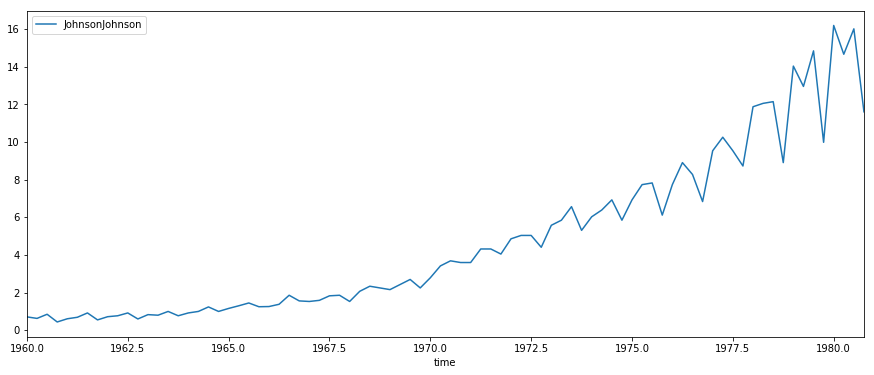

In [5]:
jj = pdsd("JohnsonJohnson")
jj.plot(x="time",y="JohnsonJohnson",figsize=[15,6])

Original:
```R
# log-return of Johnson&Johnson
jj.log.return=diff(log(JohnsonJohnson))
jj.log.return.mean.zero=jj.log.return-mean(jj.log.return)

# Plots for log-returns
par(mfrow=c(3,1))
plot(jj.log.return.mean.zero, main='Log-return (mean zero) of Johnson&Johnosn earnings per share')
acf(jj.log.return.mean.zero, main='ACF')
pacf(jj.log.return.mean.zero, main='PACF')
```

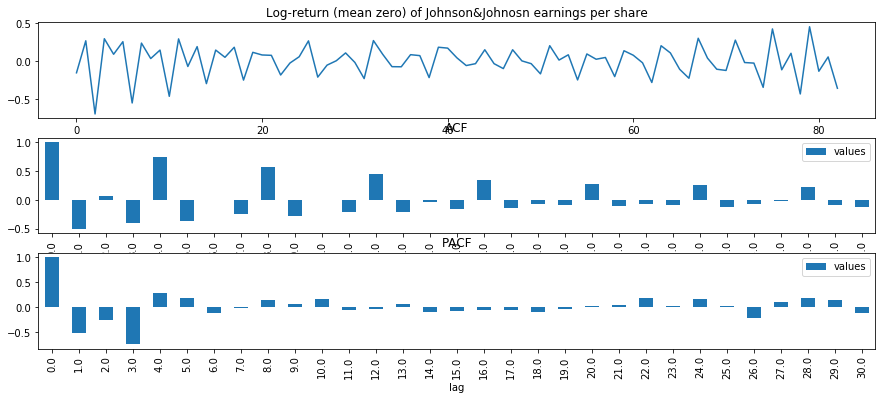

In [25]:
logret = np.diff(np.log(jj['JohnsonJohnson']))
logretmeanzero = logret - logret.mean()
# i don't like typing
dat = logretmeanzero

fig, axs = plt.subplots(3,1)
fig.set_figwidth(15)
fig.set_figheight(6)
axs[0].plot(dat)
axs[0].set_title('Log-return (mean zero) of Johnson&Johnosn earnings per share')
acf_df(dat,nlags=30).plot(x="lag",y="values",title="ACF",ax=axs[1],kind="bar")
acf_df(dat,nlags=30,mode="pacf").plot(x="lag",y="values",title="PACF",ax=axs[2],kind="bar")
plt.show()

Original:
```R
# Order
p=4
# sample autocorreleation function r
r=NULL
r[1:p]=acf(jj.log.return.mean.zero, plot=F)$acf[2:(p+1)]
# matrix R
R=matrix(1,p,p) # matrix of dimension 4 by 4, with entries all 1's.

# define non-diagonal entires of R
for(i in 1:p){
	for(j in 1:p){
		if(i!=j)
			R[i,j]=r[abs(i-j)]
	}
}
# b-column vector on the right
b=matrix(r,p,1)# b- column vector with no entries
phi.hat=solve(R,b)[,1]
# Variance estimation using Yule-Walker Estimator
c0=acf(jj.log.return.mean.zero, type='covariance', plot=F)$acf[1]

var.hat=c0*(1-sum(phi.hat*r))
# Constant term in the model
phi0.hat=mean(jj.log.return)*(1-sum(phi.hat))
cat("Constant:", phi0.hat," Coeffcinets:", phi.hat, " and Variance:", var.hat, '\n')
```

In [32]:
p=4
r = sts.acf(dat)[1:p+1]
R = np.ones((p,p))
for i in range(p):
    for j in range(p):
        if i!=j:
            R[i,j] = r[abs(i-j)-1]

phihat = np.linalg.solve(R,r)
c0 = sts.acovf(dat)[0]
varhat = c0*(1-(phihat*r).sum())
phi0hat = logret.mean() * (1-phihat.sum())
print("Constant: %.4f, Coefficients: %s and Variance: %.4f" % (phi0hat, phihat, varhat))

Constant: 0.0798, Coefficients: [-0.6293 -0.5172 -0.4883  0.2651] and Variance: 0.0142
